<a href="https://colab.research.google.com/github/kanarhy15177/Kana-Rahayu_202255202007/blob/main/Klasifikasi%20fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import cv2 # This should now import successfully after installing the package
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data_dir = '/content/drive/MyDrive/Dataset Fashion'
batch_size = 32
img_size = 224

In [6]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [18]:
!pip install tensorflow # Install the tensorflow package
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import the ImageDataGenerator class

data_dir = '/content/drive/MyDrive/Dataset Fashion'  # Ganti <nama_folder> dengan nama folder Anda
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)  # 20% untuk validasi

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=(224, 224),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00
Found 1024 images belonging to 4 classes.
Found 256 images belonging to 4 classes.


In [19]:
# Get class names from the train generator
class_names = train_generator.class_indices

# Create a list of file paths and their corresponding labels
file_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file_name))
        labels.append(class_names[class_name])

# Create a DataFrame from the file paths and labels
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

In [21]:
from sklearn.model_selection import train_test_split # Import the train_test_split function

# Splitting the data
train_df, test_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=8)
train_df, valid_df = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=8)

# Check the lengths
print('Train length:', len(train_df), 'Validation length:', len(valid_df), 'Test length:', len(test_df))

Train length: 614 Validation length: 154 Test length: 512


In [22]:
# Data Augmentation
height, width, channels = 128, 128, 3
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Convert 'label' column to string type
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)


# Correct x_col to 'file_path'
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_path', y_col='label', target_size=(height, width), # Corrected x_col
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    valid_df, x_col='file_path', y_col='label', target_size=(height, width), # Corrected x_col
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df, x_col='file_path', y_col='label', target_size=(height, width), # Corrected x_col
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)

Found 614 validated image filenames belonging to 4 classes.
Found 154 validated image filenames belonging to 4 classes.
Found 512 validated image filenames belonging to 4 classes.


In [24]:
from tensorflow.keras.applications import VGG16 # Import the VGG16 class
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_path', y_col='label', target_size=(height, width), # Corrected column names to match DataFrame
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size,
    errors='ignore'  # Ignore corrupted images
)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=valid_gen,
    validation_steps=len(valid_df) // batch_size,
    epochs=50
)

Found 614 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 466s 53s/step - accuracy: 0.3173 - loss: 2.5332 - val_accuracy: 0.5859 - val_loss: 0.9461
Epoch 2/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.4844 - loss: 1.1878

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.4844 - loss: 1.1878 - val_accuracy: 0.6875 - val_loss: 0.8243
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 114s 13s/step - accuracy: 0.5183 - loss: 1.0694 - val_accuracy: 0.6641 - val_loss: 0.7428
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5781 - loss: 0.9193 - val_accuracy: 0.6641 - val_loss: 0.7145
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 120s 14s/step - accuracy: 0.6432 - loss: 0.8670 - val_accuracy: 0.7891 - val_loss: 0.5989
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.7368 - loss: 0.7935 - val_accuracy: 0.7734 - val_loss: 0.6046
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 115s 13s/step - accuracy: 0.6928 - loss: 0.7612 - val_accuracy: 0.8359 - val_loss: 0.5074
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.6719 - loss: 0.7754 - val_accuracy: 0.8359 - val_loss: 0.4880
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 116s 13s/step - accuracy: 0.7148 - loss: 0.7085 - val_accuracy: 0.8594 - val_loss: 0.4512
Epoch 10/50

In [26]:
# Model Evaluation
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_df) // batch_size)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 292s 40s/step - accuracy: 0.8986 - loss: 0.2331
Test Loss: 0.2306, Test Accuracy: 0.9023


In [27]:
# Visualizing Loss Curves
import matplotlib.pyplot as plt

def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range(start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    # Added a value for the 's' argument (marker size)
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=100, c='red', label=sc_label)

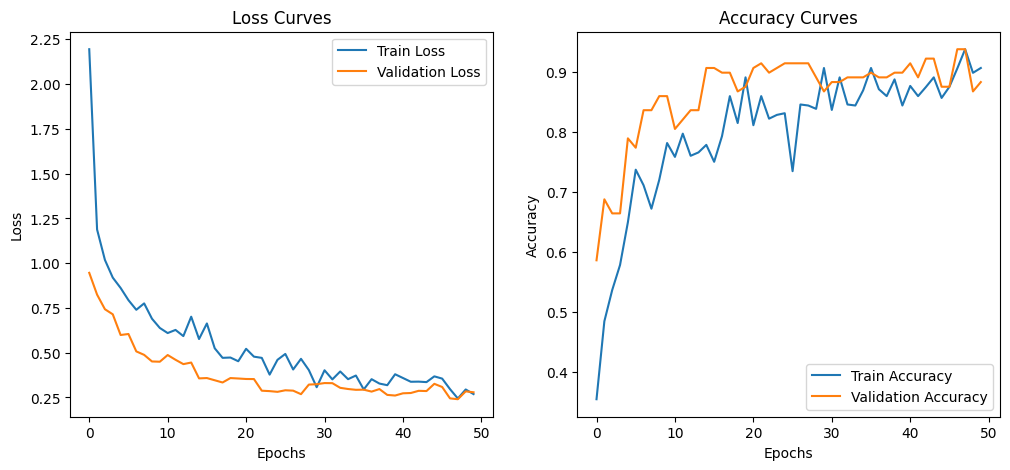

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [29]:
predictions = model.predict(test_gen, steps=len(test_df) // batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step


In [30]:
predictions = model.predict(test_gen)  # Remove steps argument
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes

# Model Evaluation
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen)  # Remove steps argument
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 10s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 10s/step - accuracy: 0.8986 - loss: 0.2331
Test Loss: 0.2306, Test Accuracy: 0.9023


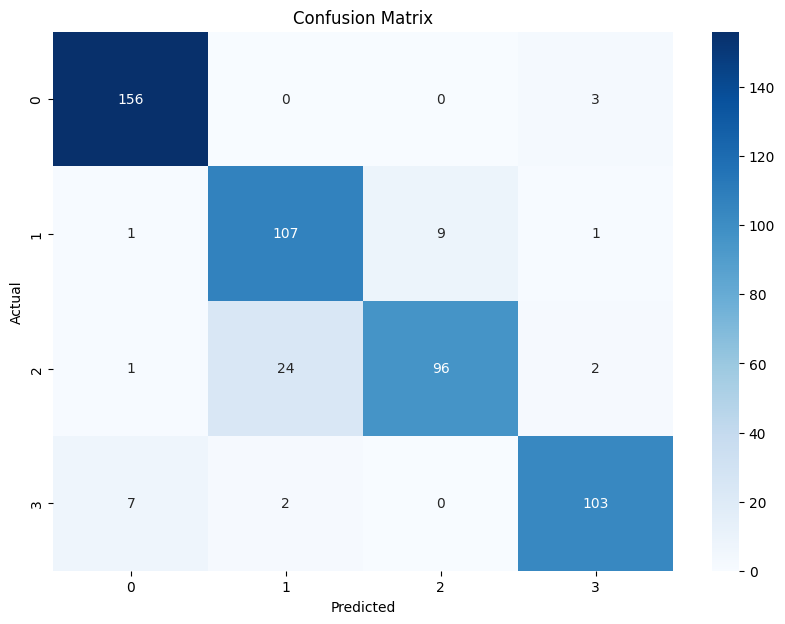

In [31]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen.class_indices.keys()), yticklabels=list(test_gen.class_indices.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [32]:
report = classification_report(true_classes, predicted_classes, target_names=list(test_gen.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       159
           1       0.80      0.91      0.85       118
           2       0.91      0.78      0.84       123
           3       0.94      0.92      0.93       112

    accuracy                           0.90       512
   macro avg       0.90      0.90      0.90       512
weighted avg       0.91      0.90      0.90       512



In [33]:
import cv2

def get_gradcam(model, img, layer_name):
    """
    Generates a Grad-CAM heatmap for a given image and model.

    Args:
        model: The trained model.
        img: The input image.
        layer_name: The name of the convolutional layer to visualize.

    Returns:
        Heatmap overlayed on the image.
    """
    # Preprocess the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Rescale
    preds = model.predict(img)  # Make prediction to define model output
    class_idx = np.argmax(preds[0])

    # Get the gradient of the top predicted class
    # Get the layer to visualize from the VGG16 model (base model)
    vgg16_model = model.get_layer('vgg16')
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,  # Use the inputs of the main model
        # Instead of model.output, use vgg16_model.output
        # Correctly access the layer output and the model's final output
        outputs=[vgg16_model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)  # Pass the image to the grad_model
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Get the output of the last convolutional layer
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()
